In [11]:
import os
import sys
import pandas as pd
import numpy as np
import seaborn
import matplotlib
import matplotlib.pyplot as plt 
import scipy
import IPython

sys.path.append('../../')
sys.path.append('../')

import utils
import readers
from readers.describe_bs_output_reader import DescribeBsOutputReader
from readers.patient_info import PatientInfo

### Edit the following variables for your own machine

In [12]:
nfs_directory_path_on_virtual_machine = '/afs/csail.mit.edu/u/t/tzhan/NFS/'
virtual_machine_username = 'tzhan'
virtual_machine_ip_address = '128.52.179.213'

### Do not edit the following variables/function definitions

In [13]:
output_dir = os.path.join(nfs_directory_path_on_virtual_machine, 'script_output', 'describe_bs')
outputReader = DescribeBsOutputReader(output_dir)
patientInfo = PatientInfo('../../../../patient_outcome_info/')

In [14]:
def get_zs_bsr_over_time_df_pt(zs_or_bsr, new_sid, ds_rate, max_num_hours):
    # ds_rate: rate at which to downsample. If not high enough, might have memory issues
    # outcome_lambda: boolean function which returns whether we want to include the patient in the plot
    # zs_or_bsr must be either 'zs' or 'bsr'
    assert(zs_or_bsr=='bsr' or zs_or_bsr=='zs'), "zs_or_bsr must be either 'zs' or 'bsr'"
    num_samples = utils.hour_to_samples(max_num_hours)/ds_rate
    
    edfs_and_indices = patientInfo.get_edfs_and_indices(new_sid, max_num_hours=max_num_hours)
    patient_zs_bsrs = np.zeros(utils.hour_to_samples(max_num_hours))
    patient_masks = np.ones(utils.hour_to_samples(max_num_hours))
    for edf_num, (edf, start_index, end_index) in enumerate(edfs_and_indices):
        if zs_or_bsr=='bsr':
            zs_bsr = outputReader.get_bsr(edf)
        else:
            zs_bsr = outputReader.get_global_zs(edf)
        patient_zs_bsrs[start_index:end_index] = zs_bsr[:(end_index-start_index)]
        patient_masks[start_index:end_index] = 0
    zs_bsrs = patient_zs_bsrs[::ds_rate]
    masks = patient_masks[::ds_rate]
        
    masks = masks.astype(bool)
    index_in_samples= np.arange(0, utils.hour_to_samples(max_num_hours), ds_rate)
    index_in_seconds = index_in_samples/(0.0+utils.sec_to_samples(1))
    minutes, seconds = np.divmod(index_in_seconds, 60)
    hours, minutes = np.divmod(minutes, 60)
    index_formatted = []
    for i in range(len(hours)):
        hour = int(hours[i])
        minute = int(minutes[i])
        time = '{}:{:02d}'.format(hour, minute)
        index_formatted.append(time)
    zs_bsrs = zs_bsrs.reshape((1,len(zs_bsrs)))
    masks = masks.reshape((1,len(masks)))
    zs_bsr_df = pd.DataFrame(zs_bsrs, index=[new_sid], columns=index_formatted)
    return zs_bsr_df, masks

In [37]:
def create_heatmap(zs_bsr_df, masks, zs_or_bsr):
    if zs_or_bsr=='bsr':
        cmap = "YlGnBu"
    else:
        cmap = "YlGnBu_r"
    num_rows = zs_bsr_df.shape[0]
    fig, ax = plt.subplots(figsize=(20,2))        
    heatmap_plot = seaborn.heatmap(zs_bsr_df, cmap=cmap, mask=masks, ax=ax)
    plt.show()
    return heatmap_plot

In [16]:
def zoom_df(df, masks, start_time_string, end_time_string):
    # start_time_string: string formatted like "0:00", indicating start time
    # end_time_string: string formatted like "0:00", indicating end time
    df = zs_bsr_df
    start_hr, start_min = start_time_string.split(':')
    end_hr, end_min = end_time_string.split(':')
    start_hr, start_min = int(start_hr), int(start_min)
    end_hr, end_min = int(end_hr), int(end_min)
    current_hr, current_min = start_hr, start_min
    times = []
    while current_hr < end_hr or (current_hr==end_hr and current_min <= end_min):
        times.append((current_hr, current_min))
        if current_min==59:
            current_hr+=1
            current_min = 0
        else:
            current_min+=1
    times = ['{:02}:{:02}'.format(hr, m) for (hr, m) in times]
    df_zoomed = df[times]

    start_index = list(zs_bsr_df.columns).index(start_time_string)
    end_index = list(zs_bsr_df.columns).index(end_time_string)+60*2
    masks_zoomed  = masks[0][start_index:end_index]
    masks_zoomed = masks_zoomed.reshape((1, len(masks_zoomed)))
    return df_zoomed, masks_zoomed

In [44]:
def convert_time_to_edf_and_index(new_sid, time_string, max_num_hours=72):
    hr, minute = time_string.split(':')
    hr, minute = int(hr), int(minute)
    num_minutes_from_start = hr * 60 + minute
    
    edfs_and_indices = patientInfo.get_edfs_and_indices(new_sid, max_num_hours=max_num_hours)

    index_in_undownsampled_merged = utils.min_to_samples(num_minutes_from_start)
    source_edf = None
    for (edf, edf_start_index, edf_end_index) in edfs_and_indices:
        if edf_start_index <= index_in_undownsampled_merged and index_in_undownsampled_merged < edf_end_index:
            source_edf = edf
            source_edf_start_index = edf_start_index
    if source_edf is None:
        return None, -1
    return source_edf, index_in_undownsampled_merged - source_edf_start_index

### Define the parameters

In [18]:
# rate at which to downsample
ds_rate = 100
# max number of hours to plot
max_num_hours = 72
# zs_bsr is either 'zs' or 'bsr', depending on which one you want to plot
zs_or_bsr = 'bsr'
# if outcome_target is 'good', makes the plot for only patients with good outcome
# if outcome_target is 'bad', makes the plot for only patients with bad outcome
outcome_target = 'good'

### Create the 72 hour plot

In [19]:
new_sid = 'ynh117'
zs_bsr_df, masks = get_zs_bsr_over_time_df_pt(zs_or_bsr, new_sid = new_sid, 
                                        ds_rate=ds_rate, max_num_hours=max_num_hours)

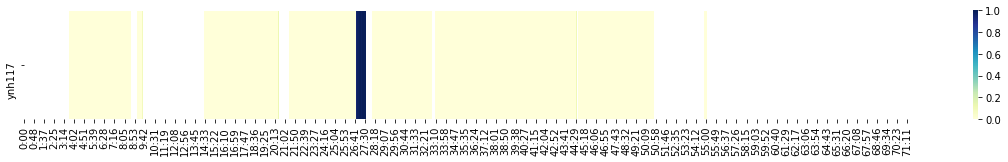

In [20]:
create_heatmap(zs_bsr_df, masks, zs_or_bsr)

### Zoom into the plot
#### adjust the time string below to zoom into desired potions

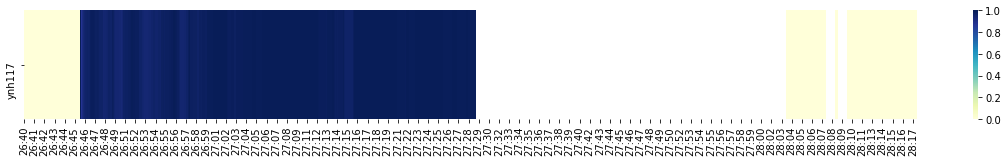

In [35]:
## Adjust the time to zoom into the desired portions of the eeg
df_zoomed, masks_zoomed = zoom_df(zs_bsr_df, masks, '26:40', '28:17')
create_heatmap(df_zoomed, masks_zoomed, zs_or_bsr)

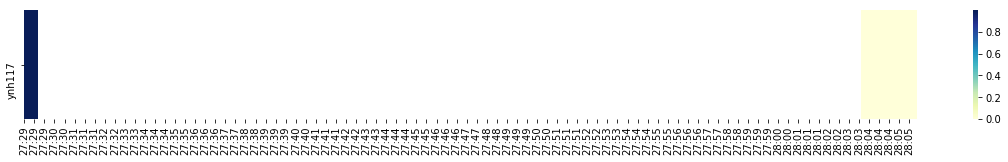

In [38]:
df_zoomed, masks_zoomed = zoom_df(zs_bsr_df, masks, '27:29', '28:05')
create_heatmap(df_zoomed, masks_zoomed, zs_or_bsr)

### How to investigate a specific point in the eeg?

In [50]:
time_of_interest = '28:03'
edf, edf_index = convert_time_to_edf_and_index(new_sid, time_of_interest)
if edf is None:
    print Exception("This time corresponds to a gap in recording (no edf for this time)")
else:
    if edf[-4:]!='.edf':
        edf = edf + '.edf'
    for dir_name, subdirs, files in os.walk(os.path.join(nfs_directory_path_on_virtual_machine, 'EEG-dataset/')):
        if edf in files:
            edf_path = os.path.join(dir_name, edf)
    print 'To investigate patient {} at time {}, follow these instructions:\n'.format(new_sid, time_of_interest)
    print "1. On your local machine, in the command terminal, cd into the folder into which you want to store the patient's edf"
    print "2. Execute the following command to copy the edf from the virtual machine into your current local folder:"
    print '\tscp {}@{}:{} .'.format(virtual_machine_username, virtual_machine_ip_address, edf_path)
    print "3. In matlab, run the interactive_vis_bs_detection:"
    print "\tChange file_path to the path to the edf you just copied. "
    print "\tCHANGE start_index TO {} ".format(edf_index)
    print "\tNote: If you are replotting the same edf at a different start index, use replot_interactive_vis_bs_detection to save time"

To investigate patient ynh117 at time 28:03, follow these instructions:

1. On your local machine, in the command terminal, cd into the folder into which you want to store the patient's edf
2. Execute the following command to copy the edf from the virtual machine into your current local folder:
	scp tzhan@128.52.179.213:/afs/csail.mit.edu/u/t/tzhan/NFS/EEG-dataset/outboxYALE/Batch1/ynh_117_2_0_20130827T035815.edf .
3. In matlab, run the interactive_vis_bs_detection:
	Change file_path to the path to the edf you just copied. 
	CHANGE start_index TO 4800 
	Note: If you are replotting the same edf at a different start index, use replot_interactive_vis_bs_detection to save time
